In [23]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model = "gpt-4o")


In [24]:
## Custom tools

def add(a:int, b:int)->int:
    """Add a and b
    Args:
        a: first int
        b: second int
    """
    return a + b
    
def multiply(a:int, b:int)->int:
    """Multiply a and b
    Args:
        a: first int
        b: second int
    """
    return a * b

def divide(a:int, b:int)->int:
    """Divide a and b
    Args:
        a: first int
        b: second int
    """
    return a / b

tools=[add, multiply, divide]


In [25]:
# integrate custom tools with llm

llm_with_tools=llm.bind_tools(tools)

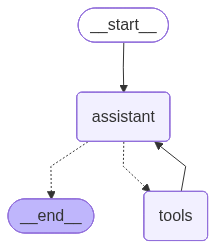

In [26]:
# Workflow with langgraph

from langgraph.graph import START, StateGraph, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message

sys_msg = SystemMessage(content= "You are a helpfull assistant tasked with performing arithmetic on a set of inputs.")

# node
def assistant(state: MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder = StateGraph(MessagesState)

## Define nodes:
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant", tools_condition
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))




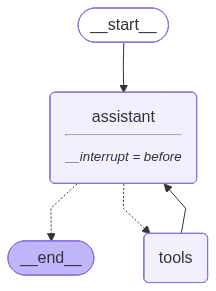

In [27]:
### Now including human in the loop

builder = StateGraph(MessagesState)

## Define nodes:
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant", tools_condition
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()

graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))


In [28]:
thread = {"configurable":{"thread_id": "123"}}
initial_input = {"messages":HumanMessage(content="Multiply 2 and 3")}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [29]:
## Continue execution

for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_bfwvM7UHCpCYMFpVUsZiHP8T)
 Call ID: call_bfwvM7UHCpCYMFpVUsZiHP8T
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [30]:
## Continue execution

for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


In [31]:
#Edit human message

thread2 = {"configurable":{"thread_id": "1"}}
initial_input = {"messages":HumanMessage(content="Multiply 2 and 3")}
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()


================================ Human Message =================================

Multiply 2 and 3


In [32]:
# Update state

graph.update_state(thread2, {"messages":[HumanMessage(content="No, Please multiply 5 and 6")]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0d06c2-7802-6dc3-8000-bda4ad4901ce'}}

In [33]:
for event in graph.stream(None, thread2, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

No, Please multiply 5 and 6
================================== Ai Message ==================================
Tool Calls:
  multiply (call_lYTVPHVmxlkfcXpq5D4Le8n0)
 Call ID: call_lYTVPHVmxlkfcXpq5D4Le8n0
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: multiply

30


In [34]:
for event in graph.stream(None, thread2, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

30
================================== Ai Message ==================================

The result of multiplying 5 and 6 is 30.


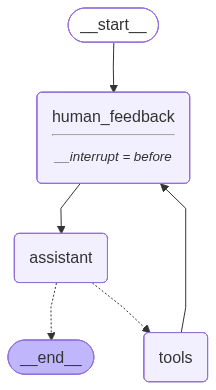

In [35]:
#### Workflow will wait for user input

sys_msg = SystemMessage(content= "You are a helpfull assistant tasked with performing arithmetic on a set of inputs.")

## human fedback node
def human_feedback(state: MessagesState):
    pass

## assistant node
def assistant(state: MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)


display(Image(graph.get_graph().draw_mermaid_png()))


In [36]:
initial_input = {"messages":"Multiply 2 and 3"}

thread = {"configurable":{"thread_id":"5"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [37]:
user_input=input("Tell me how you want to update the state:")

graph.update_state(thread,{"messages":user_input},as_node="human_feedback")
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()


================================ Human Message =================================

please multiply 5 and 6
================================== Ai Message ==================================
Tool Calls:
  multiply (call_kOxUSTSvIJDbJkjLmE4tBMHK)
 Call ID: call_kOxUSTSvIJDbJkjLmE4tBMHK
  Args:
    a: 2
    b: 3
  multiply (call_EYQMhk0NcR0JXKbaF45VQzMS)
 Call ID: call_EYQMhk0NcR0JXKbaF45VQzMS
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: multiply

30


In [38]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

30
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6, and the result of multiplying 5 and 6 is 30.
